In [2]:
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import (
    GetScaffoldForMol,
    MakeScaffoldGeneric,
    MurckoScaffoldSmilesFromSmiles
)

m = Chem.MolFromSmiles("Cc1ccccc1")
scaffold = GetScaffoldForMol(m)
Chem.MolToSmiles(scaffold)



'c1ccccc1'

In [2]:
import pandas as pd

data = pd.read_csv("../data/aqsoldb.csv")
smiles = data["SMILES"].to_numpy()
smiles

array(['[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C', 'O=C1Nc2cccc3cccc1c23',
       'Clc1ccc(C=O)cc1', ..., 'c1(cc(ccc1C(C)C)C)O',
       'COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2)cc1OC',
       'CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O'], dtype=object)

In [ ]:
import numpy as np
from rdkit import RDLogger

groups = {}
for s in smiles:
    scaffold = MurckoScaffoldSmilesFromSmiles(s)
    if scaffold == "":
        mol = Chem.MolFromSmiles(s)
        s = Chem.MolToSmiles(mol, isomericSmiles=True)
        scaffold = MurckoScaffoldSmilesFromSmiles(s)
    if scaffold in groups:
        groups[scaffold].append(s)
    else:
        groups[scaffold] = [s]

# groups = np.array([MurckoScaffoldSmilesFromSmiles(s) for s in smiles])

In [ ]:
from matplotlib import pyplot as plt

xs = np.array([n for n in range(len(groups))])
ys = np.zeros(len(groups))

for i, key in enumerate(groups.keys()):
    ys[i] = len(groups[key])

# [print(v) for v in groups.values()]
# print(len(groups))
plt.bar(xs, ys, width=50)
plt.show()
print(groups)

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_tanimoto_similarity(mols):
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]
    return [
        DataStructs.BulkTanimotoSimilarity(fp, fps) for fp in tqdm(fps)
    ]

df = data

# Convert SMILES to RDKit molecules
df['Molecule'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# Calculate Tanimoto similarity matrix
molecules = df['Molecule'].tolist()
tanimoto_matrix = calculate_tanimoto_similarity(molecules)


[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not removing hydrogen atom without neighbors
[16:47:41] WARNING: not r

In [5]:
row1 = {
    "similarity": tanimoto_matrix[0],
    "smiles": smiles,
    "LogS": data["Solubility"]
}
pd.DataFrame(row1)

tanimoto_matrix_np = np.array(tanimoto_matrix)

In [54]:
# Set random seed for reproducibility
# np.random.seed(42)

# Randomly sample molecule pairs
num_samples = 100000  # Specify the desired number of random pairs
random_indices = np.random.choice(range(len(molecules)), size=(num_samples, 2), replace=True)
# print(random_indices)

# Calculate Tanimoto difference and solubility difference for each pair of molecules
num_molecules = len(molecules)
tanimoto_diffs = []
solubility_diffs = []

with tqdm(total=num_samples, desc="Calculating similarities") as pbar:
    for idx1, idx2 in random_indices:
        tanimoto_diff = 1 - tanimoto_matrix_np[idx1, idx2]
        solubility_diff = abs(df.loc[idx1, 'Solubility'] - df.loc[idx2, 'Solubility'])
        tanimoto_diffs.append(tanimoto_diff)
        solubility_diffs.append(solubility_diff)
        pbar.update(1)

tanimoto_similarity = pd.DataFrame({
    "TanimotoDiff": tanimoto_diffs,
    "LogSDiff": solubility_diffs
}).to_csv("tanimoto_logs_data.csv")

Calculating similarities: 100%|██████████| 100000/100000 [00:05<00:00, 18401.33it/s]


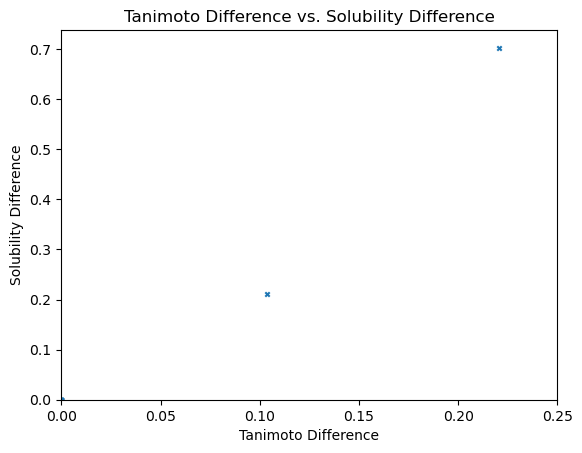

In [55]:
tanimoto_diffs = np.array(tanimoto_diffs)
solubility_diffs = np.array(solubility_diffs)


v = 0.25
plt.scatter(tanimoto_diffs[tanimoto_diffs <= v], solubility_diffs[tanimoto_diffs <= v], marker='x', s=10)
plt.xlabel("Tanimoto Difference")
plt.ylabel("Solubility Difference")
plt.xlim(0, v)  # Set x-axis limits
plt.ylim(bottom=0)  # Set y-axis limits
plt.title("Tanimoto Difference vs. Solubility Difference")
plt.show()


In [57]:
from scipy.stats import pearsonr

[pearsonr(tanimoto_diffs[tanimoto_diffs <= v], solubility_diffs[tanimoto_diffs <= v]) for v in [0.05 * n for n in range(1, 21)]]


[PearsonRResult(statistic=nan, pvalue=nan),
 PearsonRResult(statistic=nan, pvalue=nan),
 PearsonRResult(statistic=1.0, pvalue=0.0),
 PearsonRResult(statistic=1.0, pvalue=0.0),
 PearsonRResult(statistic=0.9879653388162707, pvalue=2.8804758648939835e-10),
 PearsonRResult(statistic=0.7752739390396638, pvalue=0.0001570794466431877),
 PearsonRResult(statistic=0.656893969229456, pvalue=0.00036104950796349435),
 PearsonRResult(statistic=0.5273824093467293, pvalue=0.001132191461851788),
 PearsonRResult(statistic=0.4678117649487207, pvalue=0.0007004618811673449),
 PearsonRResult(statistic=0.36386422523992834, pvalue=0.00045639743683572616),
 PearsonRResult(statistic=0.28935350135379984, pvalue=0.00019699773166113624),
 PearsonRResult(statistic=0.22276307912968746, pvalue=0.0001455117674509513),
 PearsonRResult(statistic=0.17180684724825224, pvalue=5.5379911817932925e-05),
 PearsonRResult(statistic=0.13844153452382674, pvalue=3.777777108217237e-06),
 PearsonRResult(statistic=0.11275738731052497,

In [22]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import matplotlib.pyplot as plt
from tqdm import tqdm


train = pd.read_csv("../data/train.csv")
train["molecules"] = train['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
train["fingerprint"] = train["molecules"].apply(lambda m: AllChem.GetMorganFingerprint(m, 2))

validation = pd.read_csv("../data/validation.csv")
validation["molecules"] = validation['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
validation["fingerprint"] = validation["molecules"].apply(lambda m: AllChem.GetMorganFingerprint(m, 2))


def get_similarities(fp, fps):
    # fp = AllChem.GetMorganFingerprint(mol, 2)
    # fps = [AllChem.GetMorganFingerprint(m, 2) for m in mols]
    # print(fp, fps)
    return DataStructs.BulkTanimotoSimilarity(fp, fps)

train_fps = list(train["fingerprint"])
validation_fps = list(validation["fingerprint"])
sim = np.zeros((len(validation), len(train)))

for i in tqdm(range(len(validation)), total=len(validation)):
    sim[i] = np.array(get_similarities(validation_fps[i], train_fps))


[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not removing hydrogen atom without neighbors
[21:24:39] WARNING: not r

In [25]:
# for i in tqdm(range(len(sim))):
#     sim[i, np.argsort(sim, axis=1)[i]][-100:]

query = "N1N=CC=CC2=CC=CC=C12"
q_sims = np.array(get_similarities(
    AllChem.GetMorganFingerprint(Chem.MolFromSmiles(query), 2),
    train_fps
))

train[['SMILES', 'logS']].iloc[np.argsort(q_sims)[-100:]].to_csv("../data/temp_dataset.csv", index=False, )